In [3]:
import numpy as np
from deap import base
from deap import creator
from deap import tools
import random
import pandas as pd
from deap import algorithms
import matplotlib.pyplot as plt

In [4]:
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation, get_reference_directions

# Reading From Excel File

In [5]:
df = pd.read_excel(r"C:\Users\mcf\OneDrive\Desktop\Availability (1).xlsx")

In [6]:
samples = np.asarray(df)

In [7]:
df

,country,Fertilizers,Import&Product,Export,Availability,Use,x
0,Brazil,"Ammonia, anhydrous",24144572.05,399156.28,23745415.77,2571549.00,5931.614778
1,Brazil,Ammonium nitrate (AN),21546416.92,214625.65,21331791.27,13821890.37,31882.001541
2,Brazil,Ammonium sulphate,30988444.53,53840.25,30934604.28,22805149.59,52603.066217
3,Brazil,Calcium ammonium nitrate (CAN) and other mixtu...,2020987.02,10844.03,2010142.99,1164236.84,2685.464848
4,Brazil,Diammonium phosphate (DAP),6948831.81,148854.13,6799977.68,4846157.53,11178.297447
...,...,...,...,...,...,...,...
110,Mexico,Sodium nitrate,32779.02,1030.91,31748.11,0.00,0.000000
111,Mexico,Superphosphates above 35%,622825.23,2467787.77,-1844962.54,811919.38,1699.959390
112,Mexico,"Superphosphates, other",0.00,0.00,0.00,21682383.00,45397.574551
113,Mexico,Urea,21917270.86,303460.75,21613810.11,8931655.72,18700.689238


#### In this part we will convert the fertalize names and country names to numbers

In [8]:
country = pd.factorize(df['country'])[0]
fert = pd.factorize(df['Fertilizers'])[0]

In [9]:
samples[:,0] = country
samples[:,1] = fert

In [10]:
samples.shape

(115, 7)

# EC Code
#### in this part we will use availability and production as a fitness functions per country

In [11]:
creator.create("Fitness", base.Fitness, weights = (1.0,))
creator.create("Individual", np.ndarray, fitness = creator.Fitness)

In [12]:
IND_SIZE = 22
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
def evaluation (individual):
    result1 = 0
    result2 = 0
    for i in range (22):
        temp = individual[i]
        for j in range (115):
            if samples [j,0] == 4 and samples [j,1] == individual[i]:
                result1 += samples[j,4] * (23 - i)
                result2 += samples[j,6] * (23 - i)
    return (result1 + result2),

In [14]:
def mutInv (individual):
    index1 = random.randint(0,12)
    index2 = random.randint(13,21)
    for i in range(index1, index2):
        temp = individual[i]
        individual[i] = individual[index2-i]
        individual[index2-i] = temp
    return individual

In [15]:
toolbox.register("evaluate", evaluation)
toolbox.register("cx_pm", tools.cxPartialyMatched)
toolbox.register("cx_onepoint", tools.cxOnePoint)
toolbox.register("cx_twopoint", tools.cxTwoPoint)
toolbox.register("mut_shuffle", tools.mutShuffleIndexes)
toolbox.register("mut_inverse", mutInv)
# indpb = random.randint(0,10)/10)
#toolbox.register("select", tools.selTournament, tournsize = 10)
toolbox.register("sel_roulette", tools.selRoulette)
toolbox.register("sel_best", tools.selBest)
toolbox.register("sel_worst", tools.selWorst)
toolbox.register("sel_random", tools.selRandom)


In [16]:

def main (selection, CX, mutation, CXPB, MUTPB, tsize, popul):
    res= np.zeros (200)
    toolbox.register("sel_trnmnt", tools.selTournament, tournsize = tsize)
    pop = toolbox.population(n = popul)
    fitnesses = list (map (toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    #CXPB, MUTPB = 0.8, 0.8
    fits = [ind.fitness.values[0] for ind in pop]
    g = 0
    while g < 50:
        
        #print ('--Generation %i---' %g)
        if selection == 'trnmnt':
            offspring = toolbox.sel_trnmnt(pop, len(pop))
        elif selection == 'roulette':
            offspring = toolbox.sel_roulette(pop, len(pop))
        elif selection == 'best':
            offspring = toolbox.sel_best(pop, len(pop))
        elif selection == 'worst':
            offspring = toolbox.sel_worst(pop, len(pop))
        elif selection == 'random':
            offspring = toolbox.sel_random(pop, len(pop))
        
        #toolbox.clone() method ensure that we don’t use a reference to the individuals but an completely independent instance.
        offspring = list(map(toolbox.clone, offspring))
                # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                if CX == 'onepoint':
                    toolbox.cx_onepoint(child1, child2)
                elif CX == 'twopoint':
                    toolbox.cx_twopoint(child1, child2)
                elif CX == 'pmx':
                    toolbox.cx_pm(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                if mutation == 'shuffle':
                    toolbox.mut_shuffle(mutant, random.random())
                elif mutation == 'inverse':
                    toolbox.mut_inverse(mutant)
                del mutant.fitness.values
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
       # print("  Min %s" % min(fits))
       # print("  Max %s" % max(fits))
       # print("  Avg %s" % mean)
       # print("  Std %s" % std)
        res[g] = max(fits)
        g = g + 1
    ind = max(fits)
   # print (ind)
    # you can choose haow many best individuals wanna see by k
    winner = tools.selBest(pop, k = 1)
    return res, winner

In [17]:
Selectlist = ['trnmnt', 'roulette', 'best', 'worst', 'random']
CXlist = ['onepoint', 'twopoint', 'pmx']
mut = ['shuffle', 'inverse']

In [21]:
class MyProblem (Problem):

    def __init__(self):
        super().__init__(n_var=7,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([0,0,1,100,0,0,0]),
                         xu=np.array([10,10,100,400,4,2,1]))

    def _evaluate(self, X, out, *args, **kwargs):
        #print (X.shape)
        mbf = np.zeros(X.shape[0])
        for i in range (X.shape[0]): 
            
            result, win = main (Selectlist[int(X[i,4])], CXlist[int(X[i,5])], mut[int(X[i,6])], 
                                X[i,0]/10, X[i,1]/10, int(X[i,2]), int(X[i,3])) 
            mbf[i] = -(np.mean(result, axis = None))
        
        #plt.plot(-mbf)
        #plt.show()
        out["F"] = np.column_stack([mbf])
        #out["G"] = np.column_stack([0,0])
problem = MyProblem()

In [23]:
from pymoo.model.callback import Callback
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())    


In [29]:
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.optimize import minimize

algorithm = GA(pop_size=20, eliminate_duplicates=True, save_history=True,sampling=get_sampling("int_random"))
  
res = minimize(problem, algorithm, seed=1, verbose=True,termination = ('n_gen', 20), callback=MyCallback())

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))


n_gen |  n_eval |     fopt     |     favg    
    1 |      20 | -9.01663E+08 | -4.51298E+08
    2 |      40 | -1.10844E+09 | -6.87582E+08
    3 |      60 | -1.14206E+09 | -8.90938E+08
    4 |      80 | -1.28983E+09 | -1.08024E+09
    5 |     100 | -1.32457E+09 | -1.21352E+09
    6 |     120 | -1.37688E+09 | -1.28763E+09
    7 |     140 | -1.37688E+09 | -1.32217E+09
    8 |     160 | -1.37688E+09 | -1.33616E+09
    9 |     180 | -1.37688E+09 | -1.34225E+09
   10 |     200 | -1.37688E+09 | -1.34895E+09
   11 |     220 | -1.37688E+09 | -1.35011E+09
   12 |     240 | -1.37688E+09 | -1.35242E+09
   13 |     260 | -1.37688E+09 | -1.35433E+09
   14 |     280 | -1.37688E+09 | -1.35731E+09
   15 |     300 | -1.37688E+09 | -1.36003E+09
   16 |     320 | -1.37688E+09 | -1.36092E+09
   17 |     340 | -1.37688E+09 | -1.36246E+09
   18 |     360 | -1.37688E+09 | -1.36340E+09
   19 |     380 | -1.37688E+09 | -1.36397E+09
   20 |     400 | -1.37688E+09 | -1.36476E+09
Best solution found: 
X = [9.00268

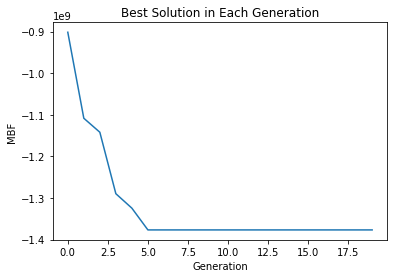

In [38]:
val = res.algorithm.callback.data["best"]
plt.plot(np.arange(len(val)), val)
plt.title("Best Solution in Each Generation")
plt.xlabel("Generation")
plt.ylabel("MBF")
plt.show()